# Sewing band structure by subduced representation

## Load modules and prepare functions

In [1]:
from __future__ import annotations

from pathlib import Path
import warnings
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

import phonopy
import seekpath
import numpy as np
import networkx as nx

import spgrep_modulation
from spgrep.group import get_little_group
from spgrep.representation import get_character
from spgrep_modulation.modulation import Modulation

%matplotlib inline

print(f"spgrep_modulation=={spgrep_modulation.__version__}")

spgrep_modulation==0.1.dev33+gc7ed76b.d20220823


In [2]:
sns.set_context("poster")
warnings.simplefilter("ignore")

In [3]:
def get_nodes(qpoint, eigenspaces):
    nodes = []
    for eigenvalue, _, irrep in eigenspaces:
        capacity = irrep.shape[1]
        character = get_character(irrep)
        nodes.append((qpoint, character, eigenvalue, capacity))
    return nodes


def enumerate_non_overlapped_paths(
    adj: dict[int, list[int]], source: int, destination: int
) -> list[list[int]]:
    all_paths = []
    while len(adj[source]) > 0:
        path = []
        head = source
        while (head != destination) and (len(adj[head]) > 0):
            path.append(head)
            head = adj[head].pop()
        all_paths.append(path[1:])  # Ignore source

    return all_paths


def sew_bands(
    ph: phonopy.Phonopy,
    start: list[float],
    stop: list[float],
    num: int = 17,
):
    nodes_info = []
    nodes = []
    ratios = np.linspace(0, 1, num=num, endpoint=True)
    for ratio in ratios:
        qpoint = np.array(start) * (1 - ratio) + np.array(stop) * ratio
        md = Modulation.with_supercell_and_symmetry_search(
            dynamical_matrix=ph.dynamical_matrix,
            supercell_matrix=[2, 2, 2],
            qpoint=qpoint,
            factor=ph.unit_conversion_factor,
        )
        nodes_info.append(
            {
                "qpoint": qpoint,
                "little_rotations": md.little_rotations,
                "little_translations": md.little_translations,
                "nodes": list(range(len(nodes), len(nodes) + len(md.eigenspaces))),
            }
        )
        nodes.extend(get_nodes(qpoint, md.eigenspaces))

    def _saw_consecutive_points(nodes_info1, nodes_info2):
        # Assume len(nodes_info1[1].shape[1]) >= len(nodes_info2[1].shape[1])
        graph = nx.DiGraph()
        graph.add_nodes_from(nodes_info1["nodes"])
        graph.add_nodes_from(nodes_info2["nodes"])

        _, _, mapping = get_little_group(
            rotations=nodes_info1["little_rotations"],
            translations=nodes_info1["little_translations"],
            kpoint=nodes_info2["qpoint"],
        )
        for node_idx1 in nodes_info1["nodes"]:
            _, character1, eigenvalue1, _ = nodes[node_idx1]
            subduced_character = character1[mapping]
            for node_idx2 in nodes_info2["nodes"]:
                _, character2, eigenvalue2, capacity2 = nodes[node_idx2]
                count = np.sum(np.conj(subduced_character) * character2) / len(mapping)
                count = np.around(np.real(count)).astype(int)
                if count >= 1:
                    # Work around to stop min-cost-flow algorithm
                    weight = abs(eigenvalue1 - eigenvalue2)
                    weight = int(weight * 1e3)
                    graph.add_edge(node_idx1, node_idx2, weight=weight, capacity=capacity2)

        source = len(nodes) + 1
        destination = source + 1
        demand = 3 * len(ph.primitive)  # Number of branches
        graph.add_node(source, demand=-demand)
        graph.add_node(destination, demand=demand)
        for node_idx1 in nodes_info1["nodes"]:
            capacity = nodes[node_idx1][3]
            graph.add_edge(source, node_idx1, weight=0, capacity=capacity)
        for node_idx2 in nodes_info2["nodes"]:
            capacity = nodes[node_idx2][3]
            graph.add_edge(node_idx2, destination, weight=0, capacity=capacity)

        flowdict = nx.min_cost_flow(graph)

        active_edges = {}
        for src, dst_flow in flowdict.items():
            for dst, flow in dst_flow.items():
                if src in active_edges:
                    active_edges[src].extend([dst for _ in range(flow)])
                else:
                    active_edges[src] = [dst for _ in range(flow)]
        all_paths = enumerate_non_overlapped_paths(active_edges, source, destination)

        return all_paths

    all_paths = []
    for nodes_info1, nodes_info2 in zip(nodes_info[:-1], nodes_info[1:-1]):
        all_paths.extend(_saw_consecutive_points(nodes_info1, nodes_info2))
    # Reverse the last path
    all_paths.extend(
        [(src, dst) for (dst, src) in _saw_consecutive_points(nodes_info[-1], nodes_info[-2])]
    )

    adj = {node_idx: [] for node_idx in range(len(nodes) + 2)}
    for src, dst in all_paths:
        adj[src].append(dst)

    # Add dummy source and destination nodes
    source = len(nodes) + 1
    destination = source + 1
    for node_idx in nodes_info[0]["nodes"]:
        capacity = nodes[node_idx][3]
        adj[source].extend([node_idx for _ in range(capacity)])
    for node_idx in nodes_info[-1]["nodes"]:
        capacity = nodes[node_idx][3]
        adj[node_idx].extend([destination for _ in range(capacity)])

    connections = enumerate_non_overlapped_paths(adj, source, destination)
    return nodes, nodes_info, connections, ratios

## Prepare `Phonopy` object

In [4]:
path = Path().resolve().parent.parent / "tests" / "phonopy_mp-661.yaml.xz"
ph = phonopy.load(path)

## Sewing

In [5]:
band_path = seekpath.get_path(ph.primitive.totuple())
label1, label2 = band_path["path"][0]
nodes, nodes_info, connections, ratios = sew_bands(
    ph, band_path["point_coords"][label1], band_path["point_coords"][label2], num=129
)

## Plot band structure with connection

Yellow and light blue branches seem to be mis-identified.
They have the equivalent irreps between Gamma and M points.
Thus, there is no way to distinguish them only from symmetry.

[Text(0, 0, 'GAMMA'), Text(1, 0, 'M')]

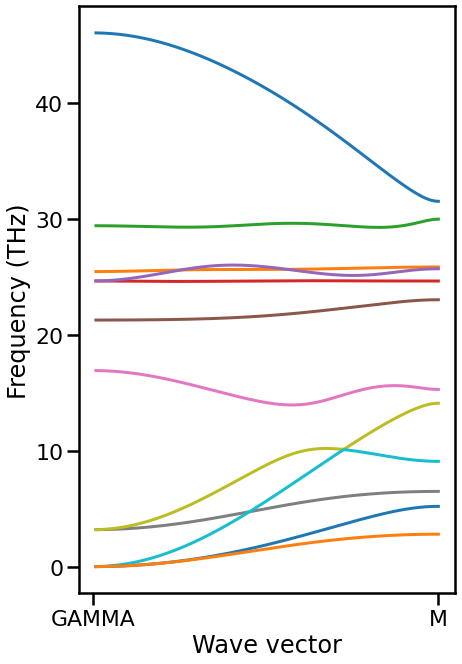

In [6]:
fig, ax = plt.subplots(figsize=(6.75, 6.75 * 1.6))
for i, (connection, ratio) in enumerate(zip(connections, ratios)):
    color = f"C{i}"
    # nodes[idx] = (qpoint, character, eigenvalue, capacity)
    frequencies = [ph.unit_conversion_factor * nodes[idx][2] for idx in connection]
    ax.plot(ratios[1:], frequencies[1:], color=color)

ax.set_xlabel("Wave vector")
ax.set_ylabel("Frequency (THz)")
ax.set_xticks([0, 1])
ax.set_xticklabels([label1, label2])